In [1]:
import numpy as np
import xarray as xr
import typhon.physics
import pyarts.recipe

In [2]:
IPFS_GATEWAY_URL = "https://ipfs.io"
IPFS_HASH = "bafybeicb33v6ohezyhgq5rumq4g7ejnfqxzcpuzd4i2fxnlos5d7ebmi3m"
RESAMPLE_PRESSURE_LEVELS = 16
SIMULATION_ALTITUDE = 15e3  # 15 km

In [4]:
pyarts.data.download()
raw_data = xr.open_dataset(f"{IPFS_GATEWAY_URL}/ipfs/{IPFS_HASH}", engine="zarr")

valid_data_mask = (raw_data.ta_qc == 0) & (raw_data.rh_qc == 0) & (raw_data.p_qc == 0)
interpolated_data = (
    raw_data[["sonde_id", "p", "rh", "ta"]]
    .where(valid_data_mask, drop=True)
    .interpolate_na(dim="altitude", fill_value="extrapolate")
)

In [5]:
vmr = xr.apply_ufunc(
    typhon.physics.relative_humidity2vmr,
    interpolated_data.rh,
    interpolated_data.p,
    interpolated_data.ta,
    output_dtypes=[float],
)
clean_data = interpolated_data.assign(vmr=vmr).sortby("altitude")

In [55]:
flux_strato = pyarts.recipe.AtmosphericFlux(
    surface_temperature=300.0, max_level_step=1000.0
)
flux_tropos = pyarts.recipe.AtmosphericFlux(
    surface_temperature=300.0, max_level_step=200.0
)
strato_atm = flux_strato.get_atmosphere()
tropos_atm = flux_tropos.get_atmosphere()

In [59]:
new_atm = {}
for variable in tropos_atm.keys():
    new_atm[variable] = np.concat(
        [strato_atm[variable][:36], tropos_atm[variable][-70:]]
    )

In [61]:
ds = clean_data.isel(sonde=0)

<xarray.Dataset> Size: 35kB
Dimensions:                (altitude: 1460)
Coordinates:
    aircraft_latitude      float32 4B 22.04
    aircraft_longitude     float32 4B -19.62
    aircraft_msl_altitude  float32 4B 1.4e+04
  * altitude               (altitude) float64 12kB 0.0 10.0 ... 1.459e+04
    sonde_time             datetime64[ns] 8B 2024-08-09T14:27:28
Data variables:
    sonde_id               object 8B 'db2bef40'
    p                      (altitude) float32 6kB 1.012e+05 ... 1.481e+04
    rh                     (altitude) float32 6kB 0.8663 0.8655 ... 0.2542
    ta                     (altitude) float32 6kB 296.4 296.3 ... 212.9 212.9
    vmr                    (altitude) float32 6kB 0.02437 0.02427 ... 3.084e-05
Attributes:
    creator_email:  helene.gloeckner@mpimet.mpg.de, theresa.mieslinger@mpimet...
    creator_name:   Helene Gloeckner, Theresa Mieslinger, Nina Robbins
    featureType:    trajectoryProfile
    history:        Level 1 ASPEN processing with Aspen V4.0.2 \nLevel 2 qual...
    keywords:       ORCESTRA, BEACH, Sounding, Dropsondes, Tropics, Atmospher...
    license:        CC-BY-4.0
    platform:       HALO
    project:        ORCESTRA, PERCUSION, MAESTRO
    references:     https://github.com/atmdrops/pydropsonde
    source:         dropsondes
    summary:        This dataset is the Level 3 BEACH dataset. It contains qu...
    title:          BEACH dropsonde dataset (Level 3)

In [70]:
new_atm["t"][-70:] = ds.ta.sortby("altitude", ascending=False).values[-1400::20]
new_atm["p"][-70:] = ds.p.sortby("altitude", ascending=False).values[-1400::20]
new_atm["H2O"][-70:] = ds.vmr.sortby("altitude", ascending=False).values[-1400::20]

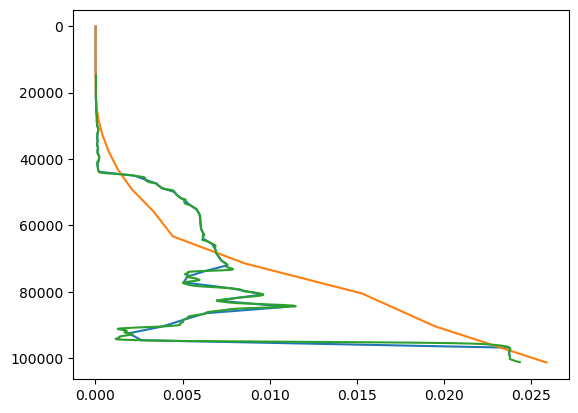

In [92]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(new_atm["H2O"], new_atm["p"])
ax.plot(tropos_atm["H2O"], tropos_atm["p"])
ax.plot(ds.vmr, ds.p)
ax.invert_yaxis()

In [80]:
new_atm["p"].size
50000 / 106

471.6981132075472

In [89]:
flux_simulator = pyarts.recipe.AtmosphericFlux(max_level_step=480.0)
atm = flux_simulator.get_atmosphere()

In [90]:
atm["p"].size

106

In [91]:
flux_simulator(atmospheric_profile=new_atm)

(Flux(name='solar', up=array([317.09631728, 317.09633017, 317.09634531, 317.09636331,
        317.09638459, 317.09641012, 317.09644093, 317.09647792,
        317.09652256, 317.09657597, 317.09664   , 317.0967166 ,
        317.09680758, 317.09691572, 317.09704303, 317.09719295,
        317.0973688 , 317.09757351, 317.0978117 , 317.0980858 ,
        317.09840069, 317.09876004, 317.09916525, 317.09961924,
        317.10011843, 317.10066175, 317.10125832, 317.10191269,
        317.10264698, 317.1035057 , 317.10451964, 317.10571579,
        317.10715555, 317.10892755, 317.11114905, 317.11411155,
        317.11763714, 317.12134352, 317.12525406, 317.12938522,
        317.13373257, 317.13830064, 317.14311602, 317.14819049,
        317.15354825, 317.15921648, 317.16523921, 317.17165091,
        317.17841776, 317.18557889, 317.19318722, 317.20126506,
        317.20991238, 317.21917429, 317.2289729 , 317.23936693,
        317.25052   , 317.26284353, 317.27607586, 317.28958726,
        317.303498